# add frames to training set
After training an initial network, identify frames that should be added to the training set by detecting low-confidence frames in tracked videos.

In [1]:
import os
os.chdir(r'D:\github\fish-tracking')  # change to github directory root dir
from deepposekit.io.utils import merge_new_images, DataGenerator
from predict.utils import analyze_video, make_tracking_video
from deepposekit.models import load_model
from deepposekit.io import VideoReader
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

# settings
old_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_11.h5'
merged_dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_12.h5'
video = r'Z:\C1\free\vids\20210204_Quin\concatenated.avi'

In [2]:
# analyze video (skip if already analyzed)
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
skeleton = r'D:\github\fish-tracking\label\skeletons\tank_skeleton_3.csv'

model = load_model(model_name)
predictions = analyze_video(video, model, skeleton, batch_size=32)
make_tracking_video(video, skeleton, predictions=predictions)

analyzing video: Z:\locker\ShareData\tank_for_rick\tank_vids\20201116_Joao\concatenated.avi
29023/29023 [==============================] - 9760s 336ms/step
making tracking video: Z:\locker\ShareData\tank_for_rick\tank_vids\20201116_Joao\concatenated_tracking.avi


928710it [45:52, 337.46it/s]


In [2]:
# inits
# (assumes video_tracking.csv already exists)
predictions = pd.read_csv(os.path.splitext(video)[0] + '_tracking.csv').to_numpy()[:,1:]
predictions = predictions.reshape((-1, int(predictions.shape[1]/3), 3))  # (frame_num X feature_num X (x,y,confidence))
reader = VideoReader(video, batch_size=1, fast_frame_count=True)
data_generator = DataGenerator(old_dataset)

found 24 peaks


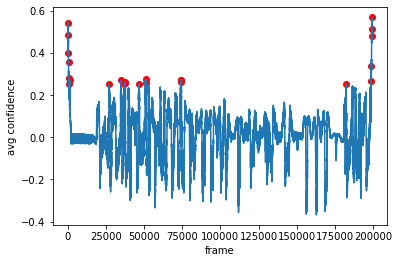

In [4]:
# show average confidence for all frames
fps = 300
min_distance = .5  # (seconds)
thresh = .25  # find frames with confidence less than (1-thresh)
smoothing = 10  # (seconds) use to smooth confidence; useful when concatenating across multiple videos

avg_unconfidence = 1 - np.mean(predictions[...,2], axis=1)  # 'un' because signal is flipped using 1 minus :)

if smoothing is not None:
    smoothing_smps = round(smoothing*fps)
    smoothing_smps += (smoothing_smps-1)//2  # make odd
    mv_avg = np.convolve(avg_unconfidence, np.ones((smoothing_smps,))/smoothing_smps, mode='same')
    avg_unconfidence = avg_unconfidence - mv_avg

peaks = find_peaks(avg_unconfidence, height=thresh, distance=fps*min_distance)[0]

ax = plt.axes(xlabel='frame', ylabel='avg confidence')
ax.plot(avg_unconfidence);
ax.scatter(peaks, avg_unconfidence[peaks], color='red');

print(f'found {len(peaks)} peaks')

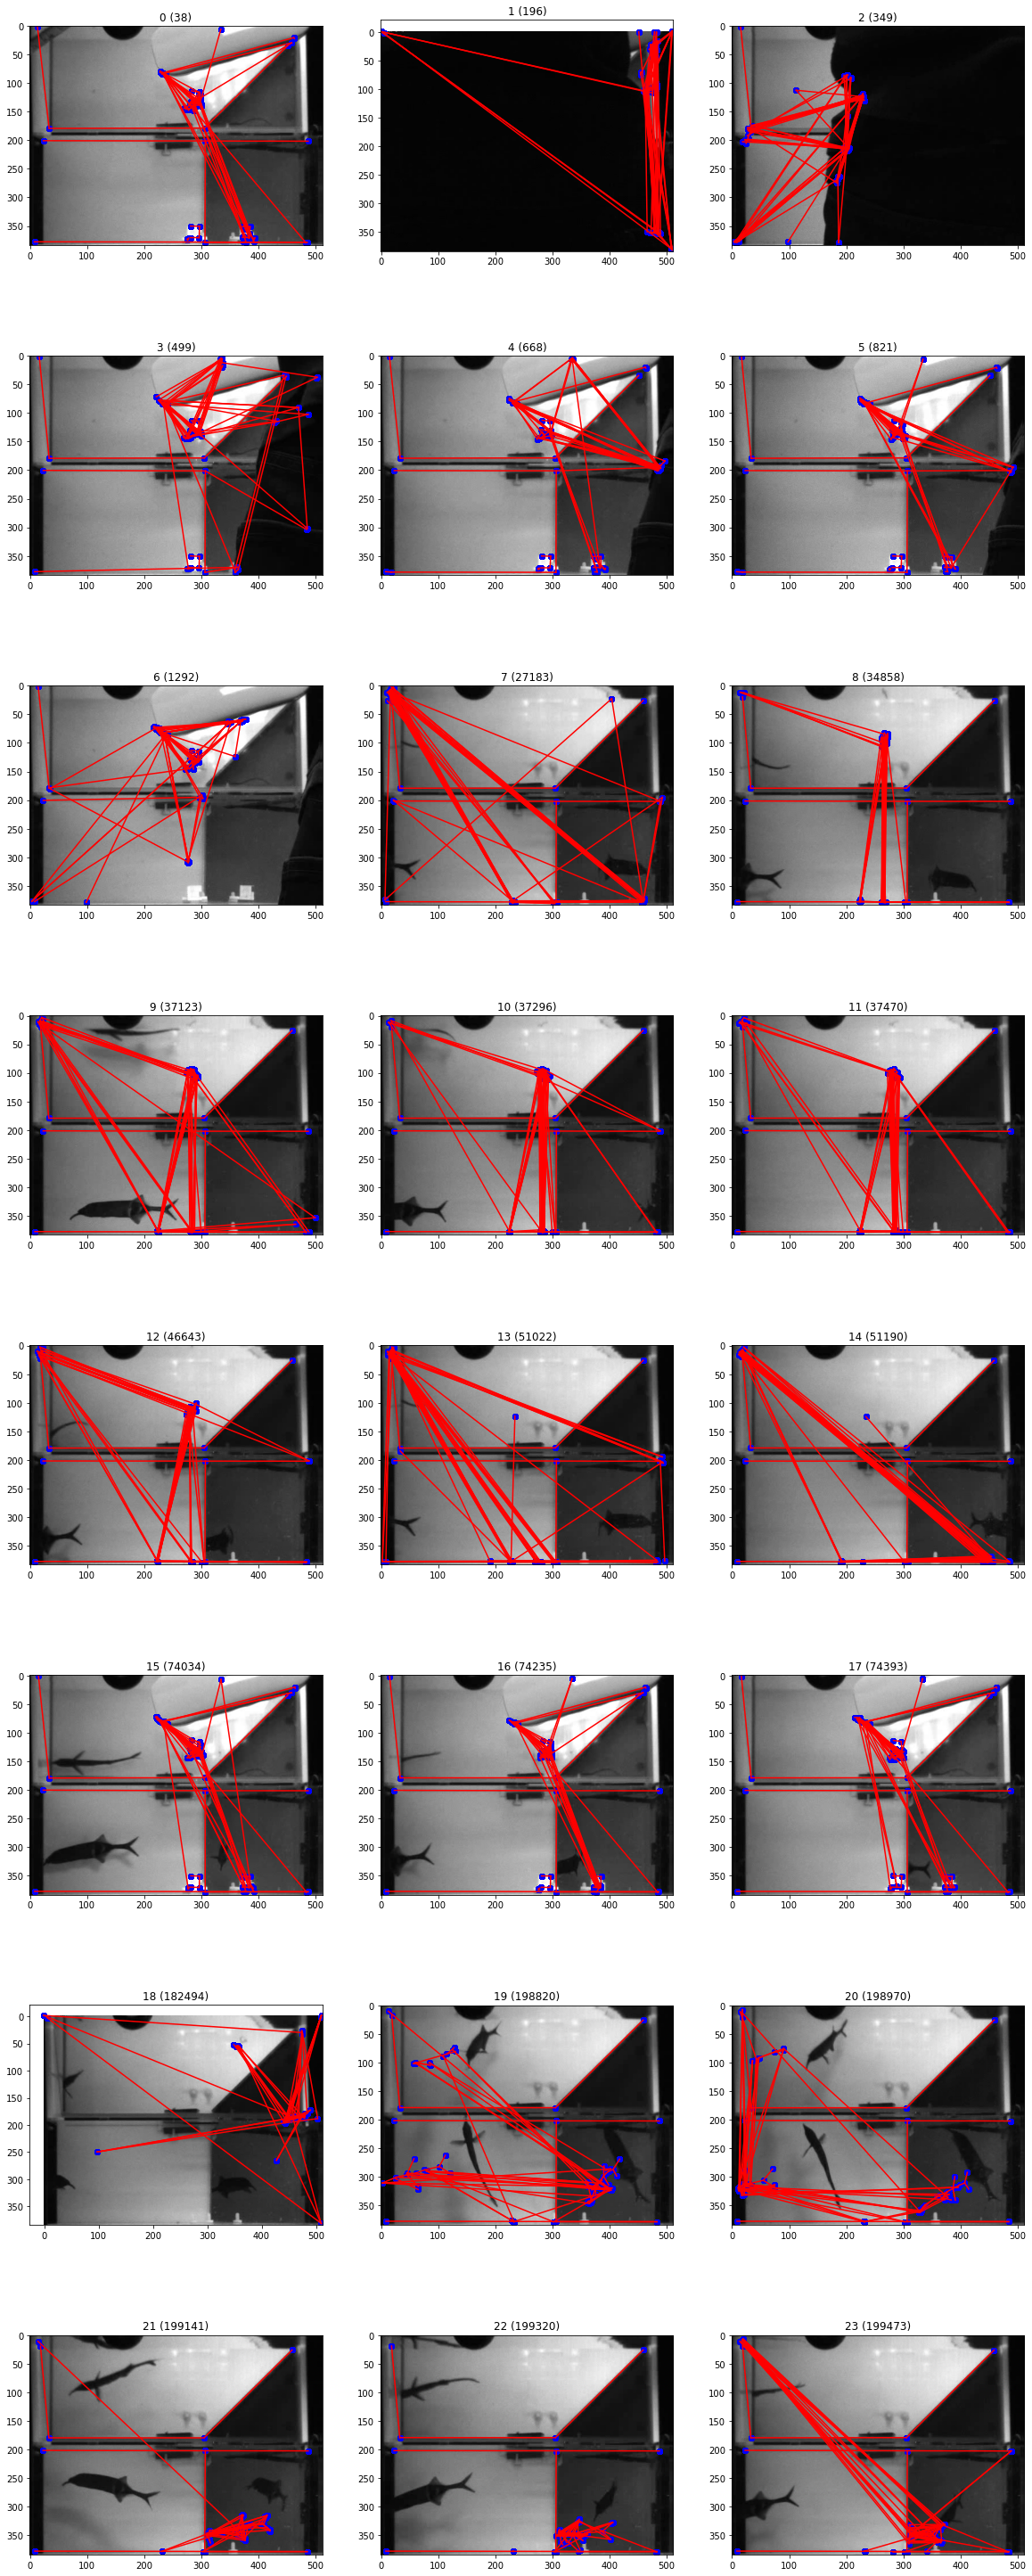

In [5]:
# show selected frames
columns = 3
rows = int(np.ceil(len(peaks)/columns))

# collect frames
imgs = []
for peak in peaks:
    imgs.append(reader[peak][0])  # this may be error prone... should cycle through images manually...
keypoints = predictions[peaks]

# plot
fig, axes = plt.subplots(rows,columns, figsize=(20,20*(rows/columns)))
for idx, img in enumerate(imgs):
    ax_idx = np.unravel_index(idx, (rows, columns))
    ax = axes[ax_idx[0], ax_idx[1]]
    ax.imshow(img)
    ax.set_title(f'{idx} ({peaks[idx]})')
    for kp_idx, jdx in enumerate(data_generator.graph):
        ax.scatter(keypoints[idx,:,0], keypoints[idx,:,1], color='blue')
        if jdx > -1 and np.all(keypoints[0, kp_idx, :]>0):
            ax.plot(
                [keypoints[idx, kp_idx, 0], keypoints[idx, jdx, 0]],
                [keypoints[idx, kp_idx, 1], keypoints[idx, jdx, 1]],
                'r-'
            )


In [9]:
# select which of the above frames to include in the new training set
# (write down the numbers NOT in parentheses in the above frames)

idxs_to_include = [2,17,20,22,25,26,27,32,34,35]
# idxs_to_include = np.arange(len(peaks))  # if you want to include all of them

In [10]:
# make merged dataset
images = np.concatenate([i[np.newaxis,:,:,0] for i in imgs])[...,np.newaxis]
merge_new_images(
    datapath=old_dataset,
    merged_datapath=merged_dataset,
    images=images[idxs_to_include],
    keypoints=keypoints[idxs_to_include],
    overwrite=False
)
